In [1]:
import numpy as np
from scipy.sparse import eye as speye
from scipy.sparse.csgraph import laplacian
from sklearn.manifold.locally_linear import (
    barycenter_kneighbors_graph, null_space, LocallyLinearEmbedding)
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix
from scipy.sparse.linalg import eigsh
from keras.datasets import mnist
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from keras.layers import Input, Dense, concatenate, Lambda
from keras.models import Model
from keras import optimizers, objectives
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.decomposition import PCA
import glob

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [36]:
original_dim = 784
batch_size = 100
intermediate_dim = 256
latent_dim = 10

x = Input(batch_shape=(batch_size, original_dim))
sp = Input(batch_shape=(batch_size, latent_dim), name="inp_s")
h = Dense(intermediate_dim, activation='relu', name="h")(x)
z_mean = Dense(latent_dim, name="z_mean")(h)
z_log_sigma = Dense(latent_dim, name="z_log_sigma")(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model([x, sp], x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

beta = 2
def vae_loss(x, x_decoded_mean):
#     xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
#     bott_loss = objectives.binary_crossentropy(sp, z)
#     print(sp.shape)µ
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    
    l = 1
    return K.sqrt(K.sum(K.square(x - x_decoded_mean), axis=-1)) + l*K.sqrt(K.sum(K.square(z - sp), axis=-1)) + kl_loss
#     return xent_loss 
#     return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [37]:
# s = Input(batch_shape=(batch_size, latent_dim))
# zs = Lambda(lambda x: x)(s)
# StoLoss = Model(s, zs)
# z_mean.shape

In [38]:
sbtr = [x_train[x:x+100] for x in range(0, len(x_train), 100)]

In [40]:
for prout in range(0,50):
    for x in sbtr[:-1]:

        bottleneck = encoder.predict(x)

        S = LLEC(n_components=2, n_neighbors=8).fit_W(bottleneck)
        sdotB = np.dot(S, bottleneck)

        lss = vae.train_on_batch([x, sdotB], x)
    print("epoch ", prout, " ",lss)
#         break
#     break

epoch  0   4.674046
epoch  1   4.7298784
epoch  2   4.6879206
epoch  3   4.7442
epoch  4   4.7439938
epoch  5   4.6793175
epoch  6   4.7304354
epoch  7   4.6833987
epoch  8   4.6917357
epoch  9   4.6893773
epoch  10   4.7645583
epoch  11   4.7808557
epoch  12   4.7020974
epoch  13   4.751964
epoch  14   4.706744
epoch  15   4.7114615
epoch  16   4.708125
epoch  17   4.7527637
epoch  18   4.6731462
epoch  19   4.7515926
epoch  20   4.7887087
epoch  21   4.6777534
epoch  22   4.7608776
epoch  23   4.669378
epoch  24   4.754296
epoch  25   4.6893744
epoch  26   4.70792
epoch  27   4.6751976
epoch  28   4.7011385
epoch  29   4.6488194
epoch  30   4.723621
epoch  31   4.6782103
epoch  32   4.662765
epoch  33   4.790336
epoch  34   4.7545824
epoch  35   4.650647
epoch  36   4.8074427
epoch  37   4.706589
epoch  38   4.7332873
epoch  39   4.6802363
epoch  40   4.726134
epoch  41   4.686756
epoch  42   4.731572
epoch  43   4.702406
epoch  44   4.6887984
epoch  45   4.666411
epoch  46   4.76116

In [99]:
sdotB[0:1]

array([[-0.05641063, -0.06180881,  0.17179224,  0.03551203,  0.04971795,
        -0.03319795, -0.18095466, -0.17185701,  0.08577567, -0.12871341]],
      dtype=float32)

In [ ]:
model.save("dae2_lle.h5")

In [96]:
# vae.fit(x_train, x_train,
#         shuffle=True,
#         epochs=10,
#         batch_size=batch_size,
#         validation_data=(x_test, x_test))

###### Normal VAE 

In [4]:
# for beta in [3,5,9,15,30,50,70]:
    beta = 1
    original_dim = 784
    batch_size = 32
    intermediate_dim = 256
    latent_dim = 10

    x = Input(batch_shape=(batch_size, original_dim))
    h = Dense(intermediate_dim, activation='relu', name="h")(x)
    z_mean = Dense(latent_dim, name="z_mean")(h)
    z_log_sigma = Dense(latent_dim, name="z_log_sigma")(h)

    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)
    encoder_2 = Model(x, z)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,), name="decoder_input")
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)

    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return xent_loss + beta*kl_loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    vae.fit(x_train, x_train,
        shuffle=True,
        epochs=10,
        batch_size=32,
        validation_data=(x_train, x_train))
    
    bt1 = encoder.predict(x_train)
    bt2 = encoder_2.predict(x_train)
    
#     pd.DataFrame(bt1).to_csv("result_vae/1_beta_"+str(beta)+".csv", index=False, header=False)
#     pd.DataFrame(bt2).to_csv("result_vae/2_beta_"+str(beta)+".csv", index=False, header=False)

Train on 60000 samples, validate on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 138us/step - loss: 0.2557 - val_loss: 0.2373
Epoch 2/10
60000/60000 [==============================] - 8s 128us/step - loss: 0.2280 - val_loss: 0.2190
Epoch 3/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.2143 - val_loss: 0.2103
Epoch 4/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.2087 - val_loss: 0.2070
Epoch 5/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.2062 - val_loss: 0.2048
Epoch 6/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.2045 - val_loss: 0.2041
Epoch 7/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.2034 - val_loss: 0.2029
Epoch 8/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.2025 - val_loss: 0.2023
Epoch 9/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.2019 - val_loss: 0.2

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(bt1)

In [8]:
print(adjusted_rand_score(kmeans.labels_,y_train))
print(normalized_mutual_info_score(kmeans.labels_,y_train))

0.4608801196628353
0.5613867884695977


/home/yannis/.local/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.5613867884695977

In [10]:
pd.DataFrame(bt1).to_csv("bt1.csv", index=False, header=False)

In [9]:
pd.DataFrame(y_train).to_csv("y_train.csv", index=False, header=False)

/home/yannis/.local/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


0.0

In [156]:
bottleneck_bvae2 = encoder.predict(x_train)
# pd.DataFrame(bottleneck_vae).to_csv("result_vae/bottleneck_vae.csv", index=False, header=None)

In [157]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity = 35)
Y3 = tsne.fit_transform(bottleneck_bvae2)

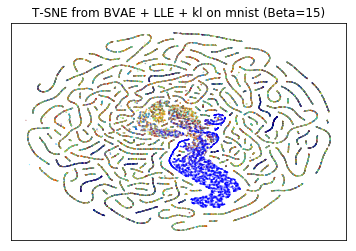

In [158]:
plt.scatter(Y3[:,0], Y3[:,1], c=list(y_train), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.title("T-SNE from BVAE + LLE + kl on mnist (Beta=15)")
plt.xticks([])
plt.yticks([])
plt.show()

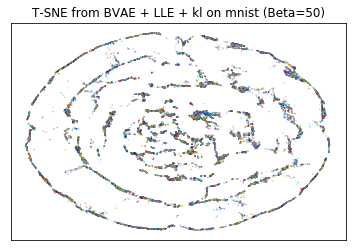

In [151]:
plt.scatter(Y2[:,0], Y2[:,1], c=list(y_train), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.title("T-SNE from BVAE + LLE + kl on mnist (Beta=50)")
plt.xticks([])
plt.yticks([])
plt.show()

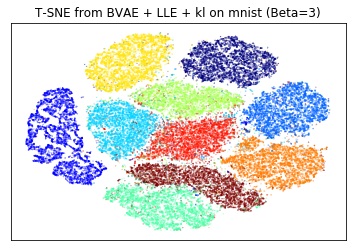

In [132]:
plt.scatter(Y[:,0], Y[:,1], c=list(y_train), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.title("T-SNE from BVAE + LLE + kl on mnist (Beta=3)")
plt.xticks([])
plt.yticks([])
plt.show()

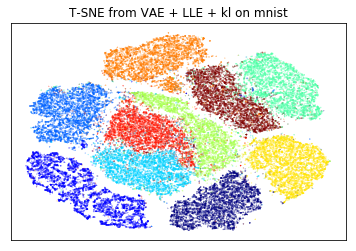

In [120]:
plt.scatter(Y[:,0], Y[:,1], c=list(y_train), cmap=plt.cm.get_cmap("jet", 10), marker='.', s=0.1)
plt.title("T-SNE from VAE + LLE + kl on mnist")
plt.xticks([])
plt.yticks([])
plt.show()

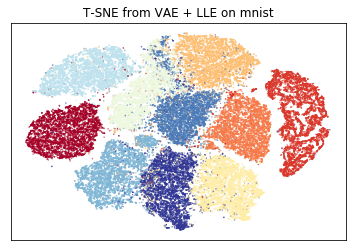

In [111]:
plt.scatter(Y[:,0], Y[:,1], c=list(y_train), cmap=plt.cm.RdYlBu,  s=0.1)
plt.title("T-SNE from VAE + LLE on mnist")
plt.xticks([])
plt.yticks([])
plt.show()

In [114]:
# pd.DataFrame(bottleneck_f).to_csv("result_vae/bottlneck.csv", index=False, header=None)
pd.DataFrame(y_train).to_csv("mnist_label.csv", index=False, header=None)

In [115]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=10, random_state=0).fit(bottleneck_f)

In [121]:
normalized_mutual_info_score(kmeans.labels_,y_train)


0.5648464962760671

In [120]:
adjusted_rand_score(y_train, kmeans.labels_)

0.471213866448161

In [35]:
class LLEC(LocallyLinearEmbedding):
    def __init__(self, n_neighbors=5, n_components=2, reg=1E-3,
                 eigen_solver='auto', tol=1E-6, max_iter=100,
                 method='standard', hessian_tol=1E-4, modified_tol=1E-12,
                 neighbors_algorithm='auto', random_state=None, n_jobs=None):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.reg = reg
        self.eigen_solver = eigen_solver
        self.tol = tol
        self.max_iter = max_iter
        self.method = method
        self.hessian_tol = hessian_tol
        self.modified_tol = modified_tol
        self.random_state = random_state
        self.neighbors_algorithm = neighbors_algorithm
        self.n_jobs = n_jobs

    def fit_transform(self, X, y=None):
        self._fit_transform(X)
        return self.embedding_
    
    def fit_W(self, X):
        self._fit_transform(X)
        return self.W.toarray()
    
    def _fit_transform(self, X):
        self.nbrs_ = NearestNeighbors(self.n_neighbors,
                                      algorithm=self.neighbors_algorithm,
                                      n_jobs=self.n_jobs)

        random_state = self.random_state
        self.nbrs_.fit(X)
        self.W = \
            locally_linear_embedding(
                self.nbrs_, self.n_neighbors, self.n_components,
                eigen_solver=self.eigen_solver, tol=self.tol,
                max_iter=self.max_iter, method=self.method,
                hessian_tol=self.hessian_tol, modified_tol=self.modified_tol,
                random_state=random_state, reg=self.reg, n_jobs=self.n_jobs)

def locally_linear_embedding(
        X, n_neighbors, n_components, reg=1e-3, eigen_solver='auto', tol=1e-6,
        max_iter=100, method='standard', hessian_tol=1E-4, modified_tol=1E-12,
        random_state=None, n_jobs=None):
    
    if eigen_solver not in ('auto', 'arpack', 'dense'):
        raise ValueError("unrecognized eigen_solver '%s'" % eigen_solver)

    if method not in ('standard', 'hessian', 'modified', 'ltsa'):
        raise ValueError("unrecognized method '%s'" % method)

    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, n_jobs=n_jobs)
    nbrs.fit(X)
    X = nbrs._fit_X

    N, d_in = X.shape

    if n_components > d_in:
        raise ValueError("output dimension must be less than or equal "
                         "to input dimension")
    if n_neighbors >= N:
        raise ValueError(
            "Expected n_neighbors <= n_samples, "
            " but n_samples = %d, n_neighbors = %d" %
            (N, n_neighbors)
        )

    if n_neighbors <= 0:
        raise ValueError("n_neighbors must be positive")

    M_sparse = (eigen_solver != 'dense')

    if method == 'standard':
        W = barycenter_kneighbors_graph(nbrs, n_neighbors=n_neighbors, reg=reg, n_jobs=1)

    
        if M_sparse:
            M = eye(*W.shape, format=W.format) - W
            M = (M.T * M).tocsr()
        else:
            M = (W.T * W - W.T - W).toarray()
            M.flat[::M.shape[0] + 1] += 1  # W = W - I = W - I

    elif method == 'hessian':
        dp = n_components * (n_components + 1) // 2

        if n_neighbors <= n_components + dp:
            raise ValueError("for method='hessian', n_neighbors must be "
                             "greater than "
                             "[n_components * (n_components + 3) / 2]")

        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        Yi = np.empty((n_neighbors, 1 + n_components + dp), dtype=np.float64)
        Yi[:, 0] = 1

        M = np.zeros((N, N), dtype=np.float64)

        use_svd = (n_neighbors > d_in)

        for i in range(N):
            Gi = X[neighbors[i]]
            Gi -= Gi.mean(0)

            # build Hessian estimator
            if use_svd:
                U = svd(Gi, full_matrices=0)[0]
            else:
                Ci = np.dot(Gi, Gi.T)
                U = eigh(Ci)[1][:, ::-1]

            Yi[:, 1:1 + n_components] = U[:, :n_components]

            j = 1 + n_components
            for k in range(n_components):
                Yi[:, j:j + n_components - k] = (U[:, k:k + 1] *
                                                 U[:, k:n_components])
                j += n_components - k

            Q, R = qr(Yi)

            w = Q[:, n_components + 1:]
            S = w.sum(0)

            S[np.where(abs(S) < hessian_tol)] = 1
            w /= S

            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] += np.dot(w, w.T)

        if M_sparse:
            M = csr_matrix(M)

    elif method == 'modified':
        if n_neighbors < n_components:
            raise ValueError("modified LLE requires "
                             "n_neighbors >= n_components")

        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        # find the eigenvectors and eigenvalues of each local covariance
        # matrix. We want V[i] to be a [n_neighbors x n_neighbors] matrix,
        # where the columns are eigenvectors
        V = np.zeros((N, n_neighbors, n_neighbors))
        nev = min(d_in, n_neighbors)
        evals = np.zeros([N, nev])

        # choose the most efficient way to find the eigenvectors
        use_svd = (n_neighbors > d_in)

        if use_svd:
            for i in range(N):
                X_nbrs = X[neighbors[i]] - X[i]
                V[i], evals[i], _ = svd(X_nbrs,
                                        full_matrices=True)
            evals **= 2
        else:
            for i in range(N):
                X_nbrs = X[neighbors[i]] - X[i]
                C_nbrs = np.dot(X_nbrs, X_nbrs.T)
                evi, vi = eigh(C_nbrs)
                evals[i] = evi[::-1]
                V[i] = vi[:, ::-1]

        # find regularized weights: this is like normal LLE.
        # because we've already computed the SVD of each covariance matrix,
        # it's faster to use this rather than np.linalg.solve
        reg = 1E-3 * evals.sum(1)

        tmp = np.dot(V.transpose(0, 2, 1), np.ones(n_neighbors))
        tmp[:, :nev] /= evals + reg[:, None]
        tmp[:, nev:] /= reg[:, None]

        w_reg = np.zeros((N, n_neighbors))
        for i in range(N):
            w_reg[i] = np.dot(V[i], tmp[i])
        w_reg /= w_reg.sum(1)[:, None]

        # calculate eta: the median of the ratio of small to large eigenvalues
        # across the points.  This is used to determine s_i, below
        rho = evals[:, n_components:].sum(1) / evals[:, :n_components].sum(1)
        eta = np.median(rho)

        # find s_i, the size of the "almost null space" for each point:
        # this is the size of the largest set of eigenvalues
        # such that Sum[v; v in set]/Sum[v; v not in set] < eta
        s_range = np.zeros(N, dtype=int)
        evals_cumsum = stable_cumsum(evals, 1)
        eta_range = evals_cumsum[:, -1:] / evals_cumsum[:, :-1] - 1
        for i in range(N):
            s_range[i] = np.searchsorted(eta_range[i, ::-1], eta)
        s_range += n_neighbors - nev  # number of zero eigenvalues

        # Now calculate M.
        # This is the [N x N] matrix whose null space is the desired embedding
        M = np.zeros((N, N), dtype=np.float64)
        for i in range(N):
            s_i = s_range[i]

            # select bottom s_i eigenvectors and calculate alpha
            Vi = V[i, :, n_neighbors - s_i:]
            alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)

            # compute Householder matrix which satisfies
            #  Hi*Vi.T*ones(n_neighbors) = alpha_i*ones(s)
            # using prescription from paper
            h = np.full(s_i, alpha_i) - np.dot(Vi.T, np.ones(n_neighbors))

            norm_h = np.linalg.norm(h)
            if norm_h < modified_tol:
                h *= 0
            else:
                h /= norm_h

            # Householder matrix is
            #  >> Hi = np.identity(s_i) - 2*np.outer(h,h)
            # Then the weight matrix is
            #  >> Wi = np.dot(Vi,Hi) + (1-alpha_i) * w_reg[i,:,None]
            # We do this much more efficiently:
            Wi = (Vi - 2 * np.outer(np.dot(Vi, h), h) +
                  (1 - alpha_i) * w_reg[i, :, None])

            # Update M as follows:
            # >> W_hat = np.zeros( (N,s_i) )
            # >> W_hat[neighbors[i],:] = Wi
            # >> W_hat[i] -= 1
            # >> M += np.dot(W_hat,W_hat.T)
            # We can do this much more efficiently:
            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] += np.dot(Wi, Wi.T)
            Wi_sum1 = Wi.sum(1)
            M[i, neighbors[i]] -= Wi_sum1
            M[neighbors[i], i] -= Wi_sum1
            M[i, i] += s_i

        if M_sparse:
            M = csr_matrix(M)

    elif method == 'ltsa':
        neighbors = nbrs.kneighbors(X, n_neighbors=n_neighbors + 1,
                                    return_distance=False)
        neighbors = neighbors[:, 1:]

        M = np.zeros((N, N))

        use_svd = (n_neighbors > d_in)

        for i in range(N):
            Xi = X[neighbors[i]]
            Xi -= Xi.mean(0)

            # compute n_components largest eigenvalues of Xi * Xi^T
            if use_svd:
                v = svd(Xi, full_matrices=True)[0]
            else:
                Ci = np.dot(Xi, Xi.T)
                v = eigh(Ci)[1][:, ::-1]

            Gi = np.zeros((n_neighbors, n_components + 1))
            Gi[:, 1:] = v[:, :n_components]
            Gi[:, 0] = 1. / np.sqrt(n_neighbors)

            GiGiT = np.dot(Gi, Gi.T)

            nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
            M[nbrs_x, nbrs_y] -= GiGiT
            M[neighbors[i], neighbors[i]] += 1
    
    return W
    a,b = null_space(M, n_components, k_skip=1, eigen_solver=eigen_solver,
                      tol=tol, max_iter=max_iter, random_state=random_state)
    
    #return a,b,W